# Dependencies

In [7]:
!pip install tensorflow

In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pylab import rcParams
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

# Data

In [9]:
csv_path = "./BTC-USD.csv"
df = pd.read_csv(csv_path, parse_dates=['Date'])
df = df.sort_values('Date')

In [13]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Matplotlib is building the font cache; this may take a moment.


Text(0, 0.5, 'Close Price (USD)')

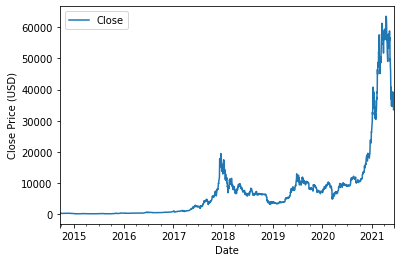

In [14]:
axis = df.plot(x='Date', y='Close');
axis.set_xlabel("Date")
axis.set_ylabel("Close Price (USD)")

# Normalization

In [16]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [18]:
scaled_close.reshape(-1, 1)

array([[0.00440947],
       [0.00389002],
       [0.0034219 ],
       ...,
       [0.58675227],
       [0.55861374],
       [0.56532431]])

# Preprocess

In [25]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

# Model

In [36]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [37]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [35]:
tf.config.list_physical_devices('GPU')

[]

In [39]:
BATCH_SIZE = 64
EPOCHS = 50

history = model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

32/32 [==============================] - 89s 3s/step - loss: nan - val_loss: nan


# Prediction

In [41]:
%matplotlib inline

NameError: name 'sns' is not defined

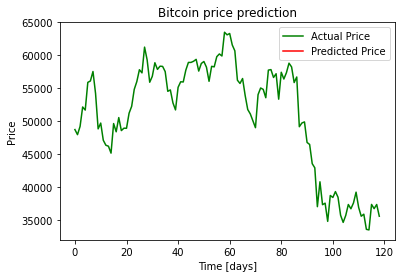

In [42]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();